In [30]:
import pandas as pd

data = pd.read_csv('../../data/processed/import_declarations_intermax_daily.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Abgabe
0,2017-01-02,439.79
1,2017-01-03,2107.94
2,2017-01-04,215.37
3,2017-01-05,0.00
4,2017-01-06,0.00


In [31]:
data['Abgabe_avg'] = data['Abgabe'].rolling(window=30).mean()

data = data.dropna(subset='Abgabe_avg')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 29 to 1044
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1016 non-null   datetime64[ns]
 1   Abgabe      1016 non-null   float64       
 2   Abgabe_avg  1016 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 31.8 KB


In [32]:
from statsmodels.tsa.tsatools import add_lag

num_lags = 3

lagged_feature = add_lag(data.Abgabe_avg, lags=2, drop=False, insert=True)
#for i in range(1, num_lags + 1):
#    lagged_features[f'Abgabe_lag_{i}'] = data['Abgabe_avg'].shift(i)
lagged_features = pd.DataFrame(lagged_feature)

new_columns = ['Lag_1', 'Lag_2', 'Lag_3']
lagged_features.columns = new_columns


df_with_lags = pd.concat([data, lagged_features], axis=1)
df_with_lags = df_with_lags.dropna(subset='Abgabe_avg')
df_with_lags

,Date,Abgabe,Abgabe_avg,Lag_1,Lag_2,Lag_3
29,2017-01-31,1045.81,414.082333,493.001667,463.024333,497.884667
30,2017-02-01,0.00,399.422667,493.001667,493.001667,463.024333
31,2017-02-02,0.00,329.158000,493.001667,493.001667,493.001667
32,2017-02-03,0.00,321.979000,493.001667,493.001667,493.001667
33,2017-02-04,0.00,321.979000,493.001667,493.001667,493.001667
...,...,...,...,...,...,...
1040,2019-11-08,1265.71,1592.881333,NaN,NaN,NaN
1041,2019-11-09,0.00,1561.454000,NaN,NaN,NaN
1042,2019-11-10,0.00,1429.151333,NaN,NaN,NaN
1043,2019-11-11,0.00,1429.151333,NaN,NaN,NaN


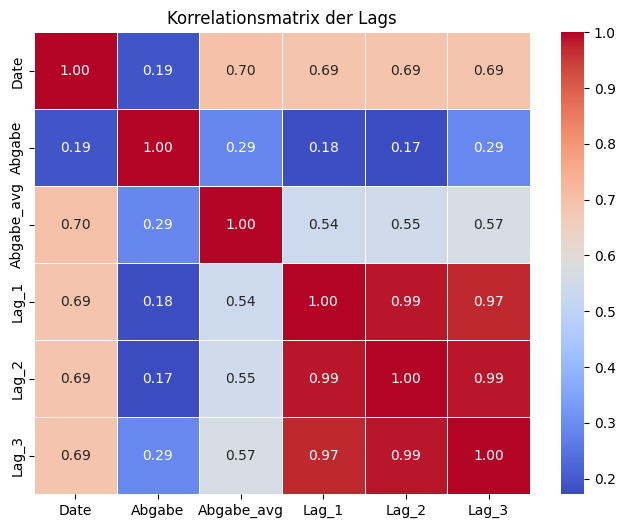

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_with_lags.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der Lags')
plt.show()

In [34]:
from data_preperation import split_data

train, test = split_data(data=df_with_lags, test_split=0.66)

train = train.dropna()

train: 670 , test: 346


In [35]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day

/tmp/ipykernel_298108/1913794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Year'] = test['Date'].dt.year
/tmp/ipykernel_298108/1913794.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Month'] = test['Date'].dt.month
/tmp/ipykernel_298108/1913794.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [36]:
X = train[['Year', 'Month', 'Day', 'Lag_1', 'Lag_2', 'Lag_3']]
y = train['Abgabe_avg']

print(X.info(), y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 29 to 698
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    670 non-null    int32  
 1   Month   670 non-null    int32  
 2   Day     670 non-null    int32  
 3   Lag_1   670 non-null    float64
 4   Lag_2   670 non-null    float64
 5   Lag_3   670 non-null    float64
dtypes: float64(3), int32(3)
memory usage: 28.8 KB
<class 'pandas.core.series.Series'>
Index: 670 entries, 29 to 698
Series name: Abgabe_avg
Non-Null Count  Dtype  
--------------  -----  
670 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB
None None


In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=120)
gb_model.fit(X, y)

gb_model

GradientBoostingRegressor(random_state=120)

In [38]:
median_values = test[['Lag_1', 'Lag_2', 'Lag_3']].median()

# Fill missing values in lag columns with respective medians
test[['Lag_1', 'Lag_2', 'Lag_3']] = test[['Lag_1', 'Lag_2', 'Lag_3']].fillna(median_values)

/tmp/ipykernel_298108/1706878876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Lag_1', 'Lag_2', 'Lag_3']] = test[['Lag_1', 'Lag_2', 'Lag_3']].fillna(median_values)


In [39]:
y_pred = pd.Series(gb_model.predict(test[['Year', 'Month', 'Day', 'Lag_1', 'Lag_2', 'Lag_3']]), index=test['Date'])

y_pred

Date
2018-12-02     800.286805
2018-12-03     800.286805
2018-12-04     786.045529
2018-12-05     786.045529
2018-12-06    2053.389980
                 ...     
2019-11-08    2044.627676
2019-11-09    2042.572789
2019-11-10    2042.572789
2019-11-11    2128.966017
2019-11-12    2128.966017
Length: 346, dtype: float64

(array([17167., 17287., 17410., 17532., 17652., 17775., 17897., 18017.,
        18140., 18262.]),
 [Text(17167.0, 0, '2017-01'),
  Text(17287.0, 0, '2017-05'),
  Text(17410.0, 0, '2017-09'),
  Text(17532.0, 0, '2018-01'),
  Text(17652.0, 0, '2018-05'),
  Text(17775.0, 0, '2018-09'),
  Text(17897.0, 0, '2019-01'),
  Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01')])

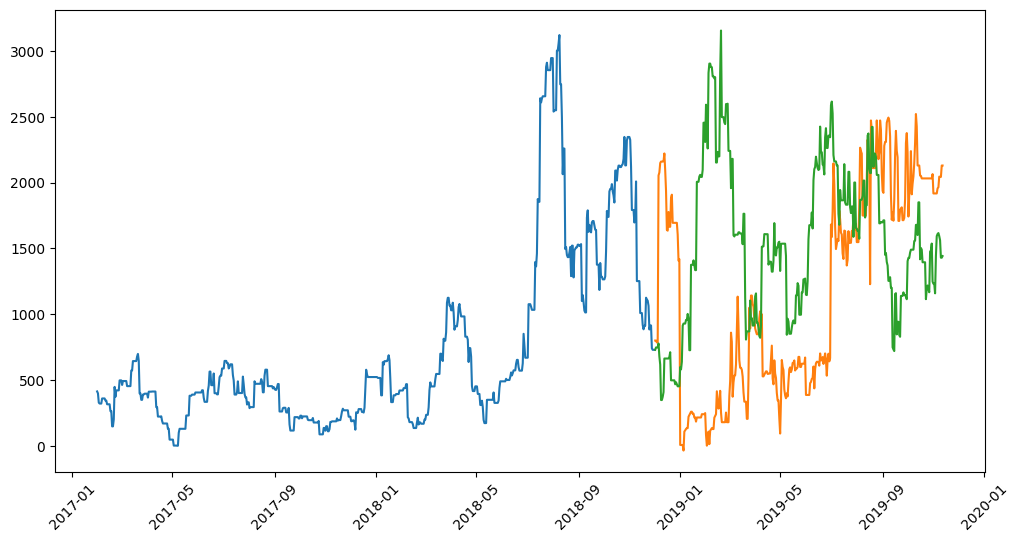

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(train.Date, train.Abgabe_avg)
plt.plot(test.Date, y_pred)
plt.plot(test.Date, test.Abgabe_avg)
plt.xticks(rotation=45)

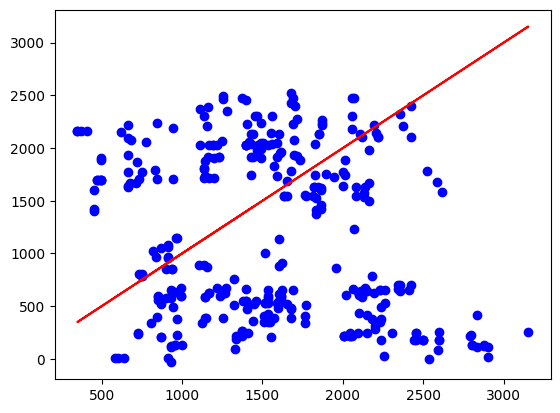

In [41]:
plt.scatter(test.Abgabe_avg, y_pred, color='blue', label='Predictions')
plt.plot(test.Abgabe_avg, test.Abgabe_avg, color='red')

In [42]:
from data_preperation import get_validation_matrix

y_pred_validation = y_pred.reset_index(drop=True)
test_validation = test.Abgabe_avg.reset_index(drop=True)


validation_results = get_validation_matrix(y_pred_validation, test_validation, train.Abgabe_avg)
validation_results['name'] = 'XGBoost'
validation_results

{'MAE': 927.5153885743986,
 'MSE': 1290156.7262879482,
 'meanMASE': 23.08041387787603,
 'r2': -2.648288012416701,
 'Forecast Bias': -388.6936692341735,
 'Forecast Accuracy (%)': 4.332677937628148,
 'name': 'XGBoost'}

In [43]:
from data_preperation import save_metrics_to_csv

save_metrics_to_csv(validation_results)

Metrics saved to metrics.csv
